# Project 5

Suraj Rampure

In [58]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import skimage as sk
from harris import *
import pandas as pd

## Part A

First, we load an image with its correspondences.

In [2]:
def read_img_pts(name):
    img = plt.imread(name)[:, :, :3]
    pts = np.load(f"points/{name}.npy")
    return img, pts

def plot_with_pts(img, pts):
    plt.figure(figsize = (8, 5))
    plt.axis('off')
    plt.imshow(img);
    plt.scatter(pts[:, 0], pts[:, 1], color = 'red', s = 10)

Now, we create our homography and warping methods.

In [9]:
def homography(pts1, pts2):
    x, y = pts1[:, 0], pts1[:, 1]
    xp, yp = pts2[:, 0], pts2[:, 1]
    n = len(x)
    A = np.zeros((2*n, 8))
    b = np.zeros(2*n,)
    
    for i in range(n):
        A[2*i, :] = np.array([x[i], y[i], 1, 0, 0, 0, -x[i] * xp[i], -y[i] * xp[i]])
        A[2*i+1, :] = np.array([0, 0, 0, x[i], y[i], 1, -x[i] * yp[i], -y[i] * yp[i]])
        
        b[2*i] = xp[i]
        b[2*i+1] = yp[i]
    
    H = np.linalg.inv(A.T @ A) @ A.T @ b
    H = np.append(H, 1)
    H = np.reshape(H, (3, 3))
    return H

In [10]:
def warp_image(img, H):
    yr, xr = img.shape[:2]
    xs = np.arange(0, xr, 1)
    ys = np.arange(0, yr, 1)
    xv, yv = np.meshgrid(xs, ys)
    ones = np.ones_like(xv)
    
    old_pts = np.vstack([xv.flatten(), yv.flatten(), ones.flatten()])
    
    new_pts = H @ old_pts
    
    bordermap = np.array([[0, 0, xr, xr],
                          [0, yr, 0, yr],
                          [1, 1, 1, 1]])
    
    newbordermap = H @ bordermap
    
    newbordermap[0, :] /= newbordermap[2, :]
    newbordermap[1, :] /= newbordermap[2, :]
    
    minX = np.min(newbordermap[0, :])
    minY = np.min(newbordermap[1, :])
    
    shiftX = int(-np.min(minX, 0))
    shiftY = int(-np.min(minY, 0))
    
    newbordermap[0, :] += shiftX
    newbordermap[1, :] += shiftY
    
    maxX = int(np.max(newbordermap[0, :]))
    maxY = int(np.max(newbordermap[1, :]))

    canvas = np.zeros((maxY, maxX, 3))

    new_pts[0, :] /= new_pts[2, :]
    new_pts[1, :] /= new_pts[2, :]
    
    new_pts = new_pts.astype('int')
    old_pts = old_pts.astype('int')
    
    new_pts[0, :] += shiftX
    new_pts[1, :] += shiftY
    
    t = img[old_pts[1, :], old_pts[0, :]]

    canvas[new_pts[1, :], new_pts[0, :]] = t
        
    return canvas   

In [11]:
def warp_image_inv(img, H):
    # This is an inverse warping! Way less artifacts.
    canvas = np.zeros_like(img)
    
    imgcopy = img.copy()
    
    yr, xr = canvas.shape[:2] 

    xs = np.arange(0, xr, 1)
    ys = np.arange(0, yr, 1)
    xv, yv = np.meshgrid(xs, ys)
    ones = np.ones_like(xv)
    target_pts = np.vstack([xv.flatten(), yv.flatten(), ones.flatten()])
    
    source_pts = np.linalg.inv(H) @ target_pts
    
    source_pts /= source_pts[2, :]
        
    minX = np.min(source_pts[0, :])
    minY = np.min(source_pts[1, :])
    
#     print(np.sort(source_pts.flatten()))
    
    shiftX = int(-np.min(minX, 0))
    shiftY = int(-np.min(minY, 0))
    
#     print(shiftX, shiftY)
    
    source_pts[0, :] += shiftX
    source_pts[1, :] += shiftY
    
    source_pts = source_pts.astype('int')

    padX = max(source_pts[0, :].max() - imgcopy.shape[1], 0) + 1
    padY = max(source_pts[1, :].max() - imgcopy.shape[0], 0) + 1
    
    imgcopy = np.pad(imgcopy, ((padY//2, padY//2 + 1), (padX//2, padX//2 + 1), (0, 0)))
    
    t = imgcopy[source_pts[1, :], source_pts[0, :]]

    canvas[target_pts[1, :], target_pts[0, :]] = t
        
    return canvas

### Rectification

#### Example 1

In [12]:
rect, rect_pts = read_img_pts("IMG_6379.png")

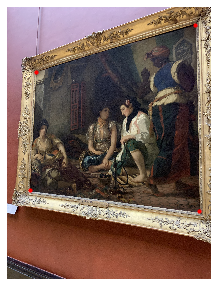

In [13]:
plot_with_pts(rect, rect_pts)

In [14]:
# It's not quite a square... rougly 5:4?
flat_pts = np.array([[0, 0], 
                     [500, 0],
                     [500, 400],
                     [0, 400]])

In [15]:
H_rect = homography(rect_pts, flat_pts)
warped_louvre = warp_image(rect, H_rect)

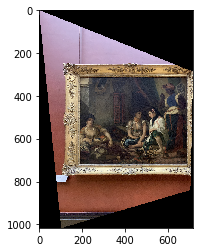

In [16]:
plt.imshow(warped_louvre);
# plt.imsave("rectified.png", warped_louvre)

#### Example 2

In [17]:
rect2, rect2_pts = read_img_pts("IMG_1456.png")

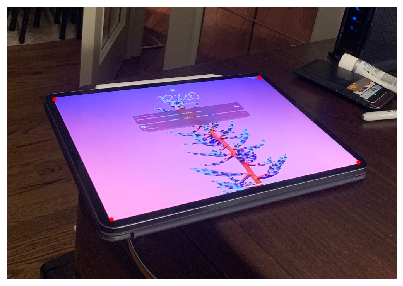

In [18]:
plot_with_pts(rect2, rect2_pts)

In [19]:
H_rect2 = homography(rect2_pts, flat_pts)
warped_ipad = warp_image(rect2, H_rect2)

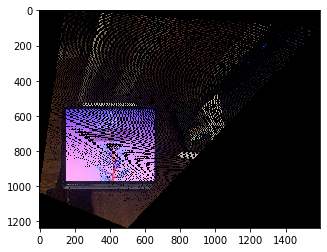

In [20]:
plt.imshow(warped_ipad);
# plt.imsave("rectified2.png", warped_ipad)

Note on the above: clearly there's some aliasing; I fixed that later on.

### Stitching

I actually warped both images to a median correspondence (as in Project 3); I found that this worked better.

In [30]:
def transform_to_median(img1, pts1, img2, pts2):
    med_pts = np.mean([pts1, pts2], axis = 0)
    hom1 = homography(pts1, med_pts)
    hom2 = homography(pts2, med_pts)
    
    warp1 = warp_image_inv(img1, hom1)
    warp2 = warp_image_inv(img2, hom2)
    
    return warp1, warp2

def create_linear_merge(w1, w2, ox, oy, mask_only = False):
    assert w1.shape == w2.shape, 'uhhh'
    
    SHAPE = ((w1.shape[0] + 2*np.abs(oy), 2 * w1.shape[1] - ox // 2, 3)) # this could require some tweaking
    
    blank1 = np.zeros(SHAPE)
    blank2 = np.zeros(SHAPE)
    mask = np.zeros(SHAPE)
    
    dim1, dim2 = w1.shape[:2]
    
    owidth = dim2 - ox
    oheight = dim1 - np.abs(oy)

    if oy < 0:
        owidth = dim2 - ox
        oheight = dim1 + oy
        
        blank1[:dim1, :dim2] = w1
        blank2[-oy:-oy+dim1, ox:ox+dim2]= w2
        mask[:dim1, :dim2] = 1
        mask[-oy:dim1, ox:dim2] = np.array([np.array([np.arange(owidth, 0, -1) / owidth for _ in range(oheight)]) for _ in range(3)]).transpose(1, 2, 0)
        
    else:
        owidth = dim2 - ox
        oheight = dim1
        
        blank1[oy:oy+dim1, :dim2] = w1
        blank2[:dim1, ox:ox+dim2] = w2
        mask[oy:oy+dim1, :dim2] = 1
        mask[:dim1, ox:dim2] = np.array([np.array([np.arange(owidth, 0, -1) / owidth for _ in range(oheight)]) for _ in range(3)]).transpose(1, 2, 0)
        
    if mask_only:
        return mask
    return mask * blank1 + (1 - mask) * blank2

#### Example 1: Kitchen

In [35]:
left, left_pts = read_img_pts("IMG_7627.png")
middle, left_middle_pts = plt.imread("IMG_7628.png")[:, :, :3], np.load("points/IMG_7628LEFT.png.npy")

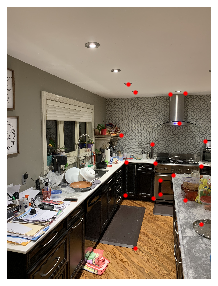

In [36]:
plot_with_pts(left, left_pts)
# plt.savefig('kitchleft.png', bbox_inches='tight')

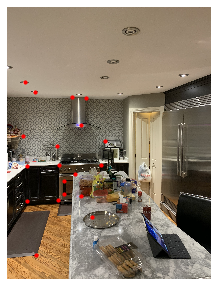

In [37]:
plot_with_pts(middle, left_middle_pts)
# plt.savefig('kitchright.png', bbox_inches='tight')

In [38]:
kit1_manual, kit2_manual = transform_to_median(left, left_pts, middle, left_middle_pts)
kitmos_manual = create_linear_merge(kit1_manual, kit2_manual, 1686, -87)

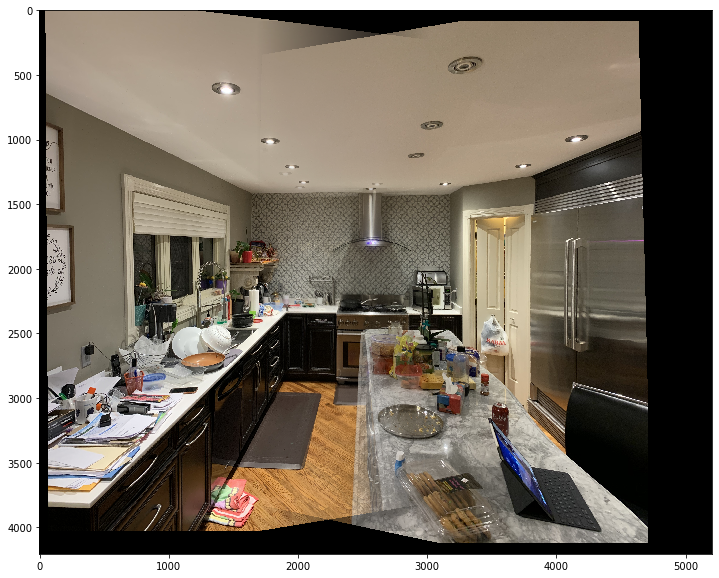

In [99]:
plt.figure(figsize = (20, 10))
plt.imshow(kitmos_manual);
# plt.imsave("merge.png", kitmos_manual)

#### Example 2: Park

In [40]:
park1, park1_pts = read_img_pts('park1.png')
park2, park2_pts = read_img_pts('park2.png')

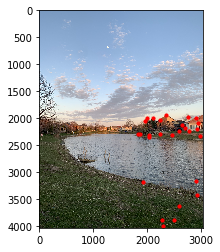

In [41]:
plt.imshow(park1);
plt.scatter(park1_pts[:, 0], park1_pts[:, 1], color = 'r', s = 10);

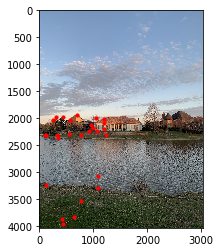

In [42]:
plt.imshow(park2);
plt.scatter(park2_pts[:, 0], park2_pts[:, 1], color = 'r', s = 10);

In [43]:
parkmos_manual = create_linear_merge(
    *transform_to_median(park1, park1_pts, park2, park2_pts),
    1898, -51)

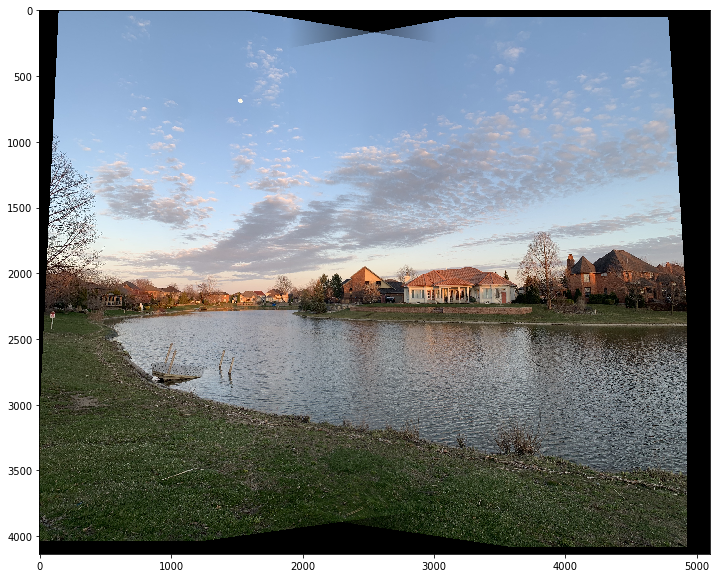

In [57]:
plt.figure(figsize = (20, 10))
plt.imshow(parkmos_manual);
# plt.imsave('parkblend.png', parkmos_manual)

#### Example 3: Backyard

In [46]:
back1, back1_pts = read_img_pts('back1.png')
back2, back2_pts = read_img_pts('back2.png')

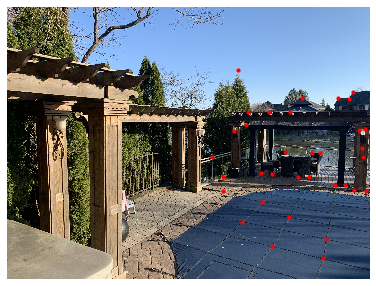

In [47]:
plot_with_pts(back1, back1_pts)

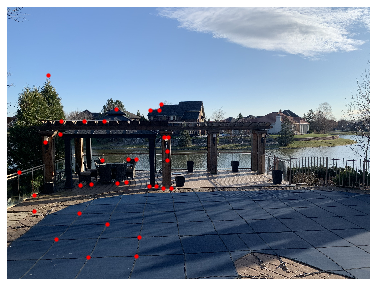

In [48]:
plot_with_pts(back2, back2_pts)

In [49]:
backmos_manual = create_linear_merge(
    *transform_to_median(back1, back1_pts, back2, back2_pts),
    2542, 86)

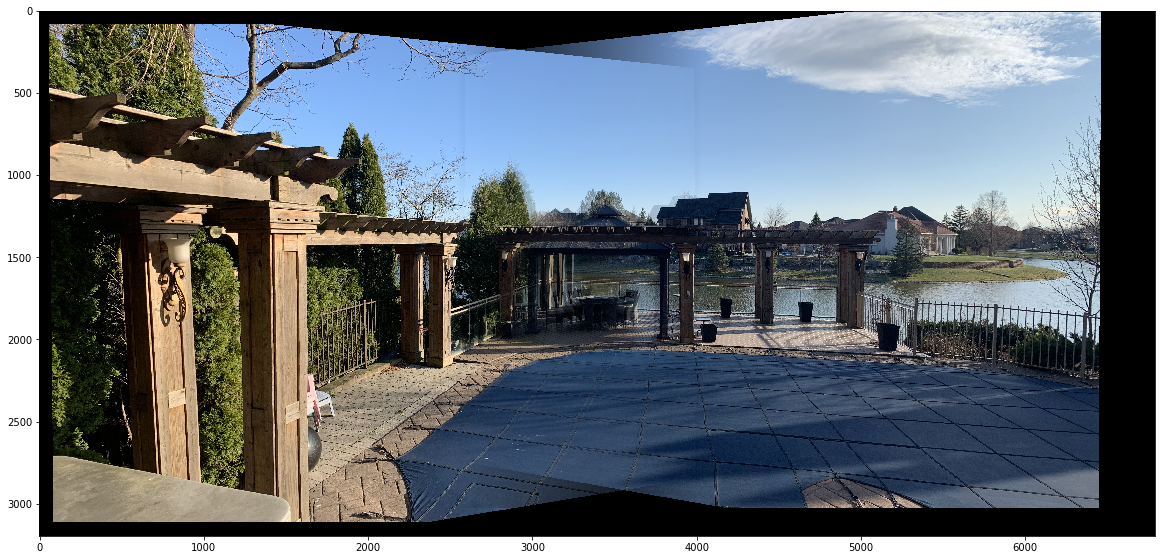

In [51]:
plt.figure(figsize = (20, 10))
plt.imshow(backmos_manual);
# plt.imsave('backmos.png', backmos)

## Part 2

The park example worked the best above, so we'll use that as our main example moving forward. However, we'll show the result of autostitching on both other examples as well (kitchen and backyard).

Note, in order for computations to be feasible, I had to reduce the dimensions of the images, by a factor of 4 in each dimension.

In [60]:
park1_small = sk.transform.resize(park1, (park1.shape[0] // 4, park1.shape[1] // 4))
park2_small = sk.transform.resize(park2, park1_small.shape)

### Step 0: Harris corners (calling provided function)

In [63]:
h1, coords1 = get_harris_corners(np.mean(park1_small, axis = 2))

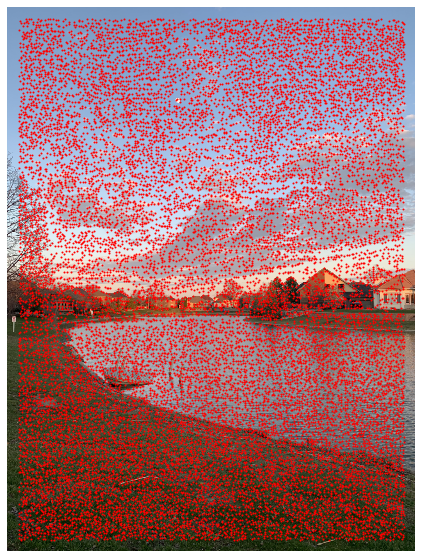

In [67]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(park1_small)
plt.scatter(coords1[1], coords1[0], s = 1, color = 'red');
# plt.savefig('harrispark.png', bbox_inches = 'tight')

### Step 1: Adaptive Non-Maximal Suprression

In [65]:
def suppression(h, coords):
    
    # get norm of all pairs of pts
    dists = dist2(coords.T, coords.T)
    
    # compute the radii
    n = coords.shape[1]
    rs = np.array([])
    f = h[coords[0], coords[1]]
    for i in range(n):
        yi, xi = coords[:, i]
        
        filtered = np.where(h[yi, xi] < 0.9 * f, dists[i, :], 10e10)
        mindist = np.min(filtered)
        rs = np.append(rs, mindist)
    
    # take top 500
    MAXNUM = 500
    rsp = pd.Series(rs)
    idx = rsp.sort_values(ascending = False).index[:MAXNUM]
    corners = coords[:, idx]
    
    return corners

In [66]:
corners1 = suppression(h1, coords1)

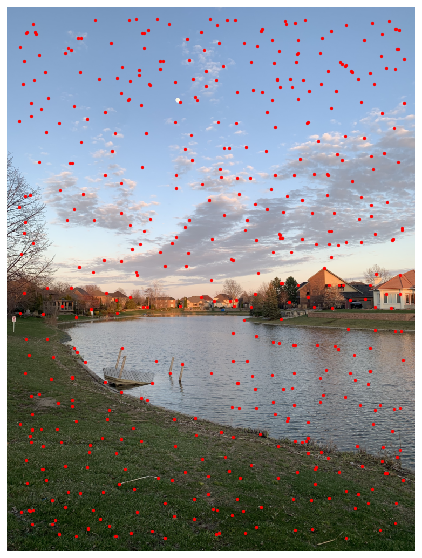

In [70]:
plt.figure(figsize = (10, 10))
plt.axis('off')
plt.imshow(park1_small)
plt.scatter(corners1[1], corners1[0], s = 5, color = 'red');
# plt.savefig('anms.png', bbox_inches = 'tight')

### Step 2: Feature Extraction

Here, we extract normalized 8 by 8 patches near each keypoint.

In [71]:
def extract_patches(image, pts):
    assert len(image.shape) == 2, 'needs to be bw'
    n = pts.shape[1]
    grid = np.zeros((n, 64))
    for i in range(n):
        yi, xi = pts[:, i]
        patch = image[yi - 20 : yi + 19 : 5, xi - 20 : xi + 19 : 5].flatten()
        patch = (patch - np.mean(patch)) / np.std(patch)
        grid[i, :] = patch
    
    return grid

In [72]:
def patches_pipeline(im):
    im2 = np.mean(im, axis = 2)
    h, coords = get_harris_corners(im2)
    supp = suppression(h, coords)
    patches = extract_patches(im2, supp)
    return (patches, supp)

In [73]:
samples1, corners1 = patches_pipeline(park1_small)
samples2, corners2 = patches_pipeline(park2_small)

### Feature Matching

In [74]:
def find_matches(samples1, corners1, samples2, corners2, t = 0.45):
    N = samples1.shape[0]
    dists = dist2(samples1, samples2)
    
    matches1 = []
    matches2 = []
    
    for i in range(N):
        row = dists[i, :]
        j = np.argmin(row)
        nn1 = np.min(row)
        nn2 = np.sort(row)[1]
        if nn1 / nn2 < t:
            matches1.append(i)
            matches2.append(j)
            
    pts1 = corners1[:, matches1]
    pts2 = corners2[:, matches2]
    
    return (pts1, pts2)

In [75]:
pts1, pts2 = find_matches(samples1, corners1, samples2, corners2, t = 0.45)

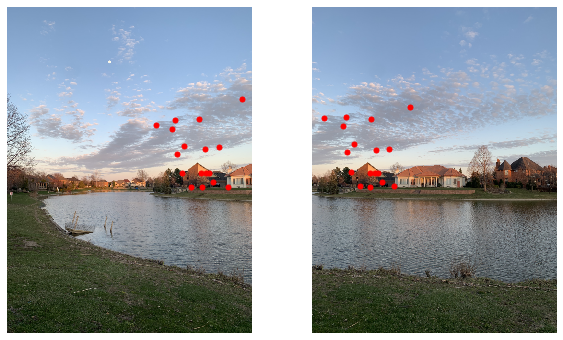

In [79]:
plt.figure(figsize = (10, 6))

plt.subplot(1, 2, 1)
plt.axis('off')
plt.imshow(park1_small)
plt.scatter(pts1[1], pts1[0], color = 'red', s = 25);

plt.subplot(1, 2, 2)
plt.axis('off')
plt.imshow(park2_small)
plt.scatter(pts2[1], pts2[0], color = 'red', s = 25);

# plt.savefig('nnpoints.png', bbox_inches = 'tight');

### RANSAC

My RANSAC method returns the largest set of inliers and not the homography itself. This is because I made the decision to continue to warp both the left and right image into a median correspondence.

In [84]:
def ransac(pts1, pts2, NUM_ITER = 2000, eps = 0.5):
    p1 = np.flip(pts1.T, axis = 1)
    p2 = np.flip(pts2.T, axis = 1)
    
    N = p1.shape[0]
    
    keep = []
    max_size = 0
    
    for _ in range(NUM_ITER):
        idx = np.random.choice(np.arange(N), size = 4, replace = False)
        sub1 = p1[idx, :]
        sub2 = p2[idx, :]
        H = homography(sub1, sub2)
        
        p2_pred = H @ np.vstack([p1.T, np.ones(len(p1))])
        p2_pred /= p2_pred[2, :]
        p2_pred = p2_pred[:2, :].T
        
        ssd = np.sum((p2_pred - p2)**2, axis = 1)
        
        matches = ssd < eps
        
        num_inliers = np.sum(matches)
        
        if num_inliers > max_size:
            keep = matches
            max_size = num_inliers
        
    fp1 = p1[keep, :]
    fp2 = p2[keep, :]
    return (fp1, fp2)

def warp_ransac(img1, img2):
    samples1, corners1 = patches_pipeline(img1)
    samples2, corners2 = patches_pipeline(img2)
    
    pts1, pts2 = find_matches(samples1, corners1, samples2, corners2)
    
    fp1, fp2 = ransac(pts1, pts2)

    warp1, warp2 = transform_to_median(img1, fp1, img2, fp2)
    
    return warp1, warp2

In [85]:
warp1, warp2 = warp_ransac(park1_small, park2_small)

In [111]:
parkmos_ransac = create_linear_merge(warp1, warp2, 1898 // 4, -51 // 4)

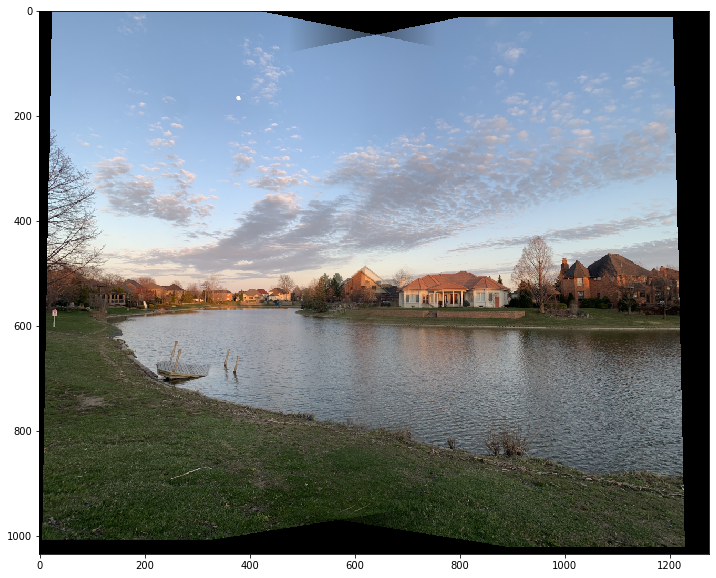

In [112]:
plt.figure(figsize = (12, 10))
plt.imshow(parkmos_ransac);
plt.imsave('parkmos_ransac.png', parkmos_ransac)

#### Backyard with Automated Stitching

In [89]:
back1, _ = read_img_pts('back1.png')
back2, _ = read_img_pts('back2.png')
back1_small = sk.transform.resize(back1, (back1.shape[0] // 4, back1.shape[1] // 4))
back2_small = sk.transform.resize(back2, back1_small.shape)

In [91]:
warpback1, warpback2 = warp_ransac(back1_small, back2_small)

In [104]:
backmos_ransac = create_linear_merge(warpback1, warpback2, 2542 // 4, 250 // 4)

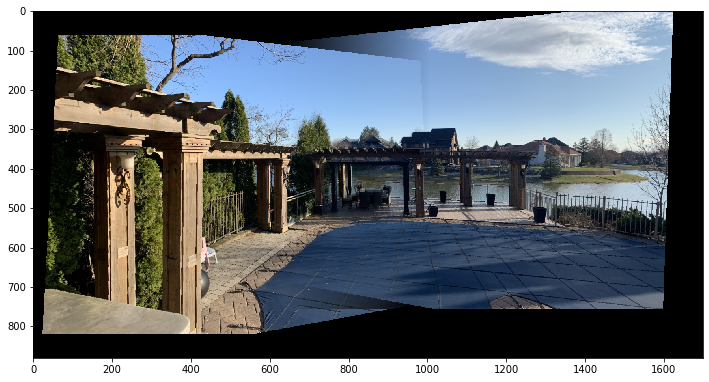

In [106]:
plt.figure(figsize = (12, 10))
plt.imshow(backmos_ransac);
# plt.imsave('backmos_ransac.png', backmos_ransac);

#### Kitchen with Automated Stitching

In [94]:
kit1 = plt.imread('IMG_7627.png')[:, :, :3]
kit2 = plt.imread('IMG_7628.png')[:, :, :3]
kit1_small = sk.transform.resize(kit1, (kit1.shape[0] // 4, kit1.shape[1] // 4))
kit2_small = sk.transform.resize(kit2, kit1_small.shape)

In [96]:
warpkit1, warpkit2 = warp_ransac(kit1_small, kit2_small)

In [113]:
kitmos_ransac = create_linear_merge(warpkit1, warpkit2, 1686 // 4, 0)

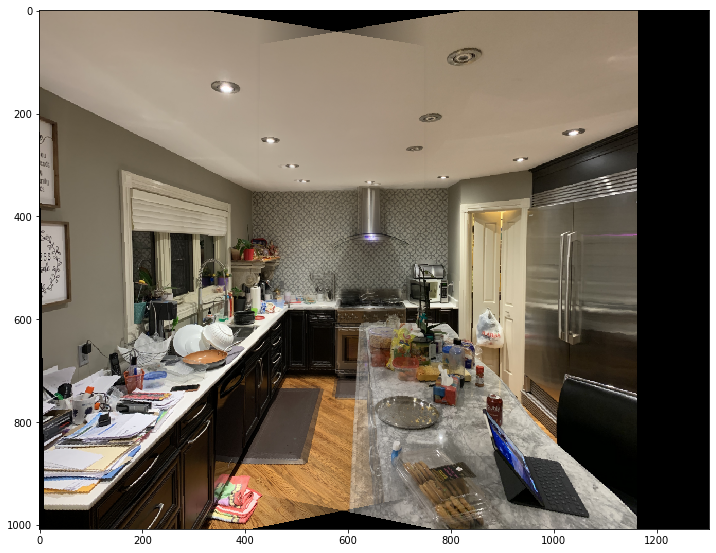

In [115]:
plt.figure(figsize = (12, 10))
plt.imshow(kitmos_ransac);
plt.imsave('kitmos_ransac.png', kitmos_ransac)